In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection
from convex_adversarial import DualNetBounds, robust_loss
%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np
from utils import *
np.random.seed(1)
torch.manual_seed(1)

fixed = True
epsilon = 0.05

In [36]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
if fixed:
    x = [(0.417022  ,  0.72032449)]
    net.load_state_dict(torch.load('random_net.pth'))
else: 
    x = [np.random.uniform(size=(2))]
    print x
    torch.save(net.state_dict(), 'random_net.pth')


X = torch.Tensor(np.array(x))
z0 = net(Variable(X))


OX = X.clone()

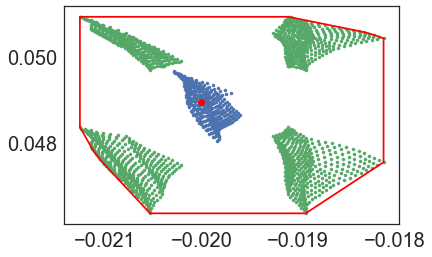

In [37]:
plt.plot(z0.data.numpy()[:,0], z0.data.numpy()[:,1], 'ro')

z_hat = []
z_bound = []
x_p = []
k = 10
for i in range(-k, k+1):
    dx = float(i) / k * epsilon
    for j in range(-k, k+1):
        dy = float(j) / k * epsilon
        X[:, 0] = OX[:, 0] + dx
        X[:, 1] = OX[:, 1] + dy
        x_p.append(X.clone().numpy())
        z_hat.append(net(Variable(X)).data.numpy())
        dual = DualNetBounds(net, Variable(X), epsilon)
        zlx, zly, zux, zuy = dual.zl[-1][0].data, dual.zl[-1][1].data, dual.zu[-1][0].data, dual.zu[-1][1].data
        p1, p2 = dual.zl[-1].data.numpy(), dual.zu[-1].data.numpy()
        p3, p4 = torch.cat([zlx, zuy]), torch.cat([zux, zly])
        z_bound.extend([p1, p2, p3, p4])


x_p, z_hat, z_bound = np.vstack(x_p), np.vstack(z_hat), np.vstack(z_bound)
plt.scatter(z_hat[:,0], z_hat[:,1], cmap="coolwarm", s=10)
plt.scatter(z_bound[:,0], z_bound[:,1], cmap="coolwarm", s=10)

max_num = len(z_bound)
x = z_bound[:,0]
y = z_bound[:,1]
#drawGraph(x,y)
mat = matrix(max_num,3) 
minn = 300
for i in range(max_num):
    mat[i][0], mat[i][1]=x[i], y[i]
    if y[i] < minn: 
        minn = y[i]
        tmp = i
d = {}  
for i in range(max_num):    
    if (mat[i][0],mat[i][1]) == (x[tmp],y[tmp]) : mat[i][2]=0
    else:mat[i][2] = math.atan2((mat[i][1] - y[tmp]), (mat[i][0] - x[tmp]))
    d[(mat[i][0],mat[i][1])] = mat[i][2]
lst = sorted(d.items(), key=lambda e : e[1]) 
for i in range(max_num):   
    ((x,y),eth0) = lst[i]
    mat[i][0], mat[i][1],mat[i][2] = x, y, eth0
stack = GrahamScan(mat)
stack.append(stack[0])
stack = np.asarray(stack)

plt.plot(stack[:,0], stack[:,1], c='r')